In [85]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

### The goal of this homework is to create a regression model for predicting housing prices `(column 'median_house_value')`.

In [86]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA
First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [123]:
filtered_ocean = df[df['ocean_proximity'].isin(['<1H OCEAN','INLAND'])].copy()
filtered_ocean = filtered_ocean.reset_index(drop=True)

filtered_ocean.fillna(0, inplace=True)

filtered_ocean.median_house_value = np.log1p(filtered_ocean.median_house_value)

data_full_train, data_test = train_test_split(filtered_ocean,test_size=0.2,random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

y_train = data_train.median_house_value.values
y_val = data_val.median_house_value.values
y_test = data_test.median_house_value.values

del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

dv = DictVectorizer(sparse=True)

train_dicts = data_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = data_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

test_dicts = data_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dicts)



## Question 1: Which feature is used for splitting the data?

Let's train a decision tree regressor to predict the `median_house_value` variable.

- Train a model with `max_depth=1`.


In [126]:
dr = DecisionTreeRegressor(max_depth=1)

dr.fit(X_train, y_train)

print(export_text(dr, feature_names=dv.get_feature_names_out()))


|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2: What's the RMSE of this model on validation?

Train a random forest model with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1` (optional - to make training faster)



In [91]:
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_regressor.fit(X_train,y_train)

y_pred = rf_regressor.predict(X_val)

rmse = mean_squared_error(y_val,y_pred, squared=False)
round(rmse,3)

0.245

## Question 3: After which value of n_estimators does RMSE stop improving? 

Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to `1`.
- Evaluate the model on the validation dataset.

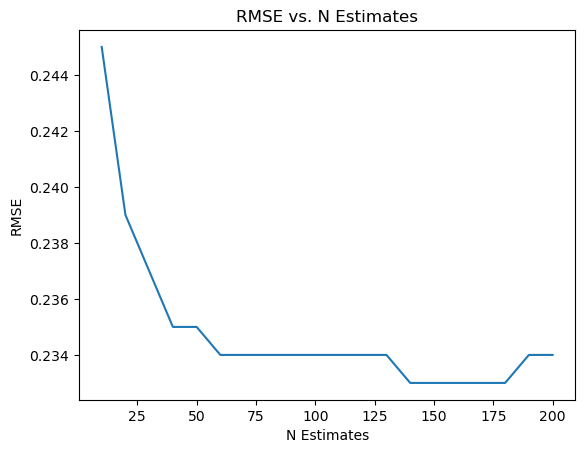

In [48]:
scores = []
for n in range(10,201,10):
    rf_regressor = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_regressor.fit(X_train,y_train)

    y_pred = rf_regressor.predict(X_val)

    rmse = mean_squared_error(y_val,y_pred, squared=False).round(3)
    scores.append((n,rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.title('RMSE vs. N Estimates')
plt.xlabel('N Estimates')
plt.ylabel('RMSE')
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4: What's the best `max_depth`, using the mean RMSE?

Let's select the best `max_depth`:

 - Try different values of `max_depth`: `[10, 15, 20, 25]`
 - For each of these values,
    - try different values of `n_estimators` from 10 till 200 (with  step 10)
    - calculate the mean RMSE
 - Fix the random seed: `random_state=1`


In [50]:
scores = []

for d in [10,15,20,25]:
    for n in range(10,201,10):
        rf_regressor = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf_regressor.fit(X_train,y_train)

        y_pred = rf_regressor.predict(X_val)

        rmse = mean_squared_error(y_val,y_pred, squared=False)
        scores.append((d,n,rmse))


df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])



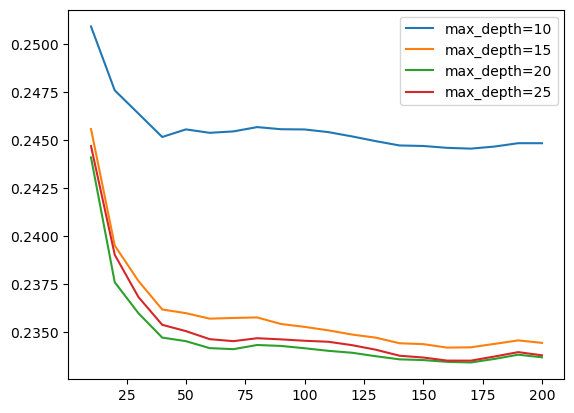

In [51]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
plt.legend()

_best max depth is 20_

## Question 5: What's the most important feature (among these 4)? 

- `total_rooms`
- `median_income`
- `total_bedrooms`
- `longitude`

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the [feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_) field.

For this homework question, we'll find the most important feature:

 - Train the model with these parameters:
    - `n_estimators=10`,
    - `max_depth=20`,
    - `random_state=1`,
    - `n_jobs=-1` (optional)
 - Get the feature importance information from this model


In [118]:
columns = ['total_rooms','median_income','total_bedrooms','longitude']

rf_regressor = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf_regressor.fit(X_train,y_train)

feature_importance = rf_regressor.feature_importances_

feature_importance_dict = dict(
    zip(list(data_train[columns]), feature_importance)
)

most_important_feature = max(feature_importance_dict, key=feature_importance_dict.get)

most_important_feature
# feature_importance_dict





'total_bedrooms'

## Question 6: Which eta leads to the best RMSE score on the validation dataset?

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta from 0.3 to 0.1.



In [72]:
! pipenv install xgboost

Installing xgboost...
Resolving xgboost...
✔ Installation Succeeded
⠋ Installing xgboost...
Installing dependencies from Pipfile.lock (ca0ab4)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [121]:
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain,'train'),(dval, 'val')]
num_boost_round = 100

model_eta_03 = xgb.train(xgb_params, dtrain, num_boost_round, evals=watchlist, verbose_eval=5)
y_pred_03 = model_eta_03.predict(dval)
rmse_03 = mean_squared_error(y_val, y_pred_03, squared=False)


xgb_params['eta']= 0.1
model_eta_01 = xgb.train(xgb_params, dtrain, num_boost_round, evals=watchlist, verbose_eval=5)
y_pred_01 = model_eta_01.predict(dval)
rmse_01 = mean_squared_error(y_val, y_pred_01, squared=False)

rmse_03, rmse_01


[0]	train-rmse:0.44350	val-rmse:0.44250


[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21444	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24522
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23570
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23318
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13259	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11496	val-rmse:0.22861
[95]	train-rmse:0.11211	val-rmse:0.22908
[99]	train-rmse:0.10989	val-rmse:0.22862
[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26538	val-rmse:0.28380
[20]	train-rmse:0.2

(0.228623199980106, 0.23208927121609343)